## [Predictions with Pyro + GPyTorch (High-Level Interface)](https://docs.gpytorch.ai/en/stable/examples/07_Pyro_Integration/Pyro_GPyTorch_High_Level.html#Predictions-with-Pyro-+-GPyTorch-(High-Level-Interface))

In [4]:
import math
import torch
import pyro
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
train_x = torch.linspace(0.,1,21)
train_y = torch.pow(train_x, 2).mul_(3.7)
train_y = train_y.div_(train_y.max())
train_y += torch.randn_like(train_y).mul_(0.02)


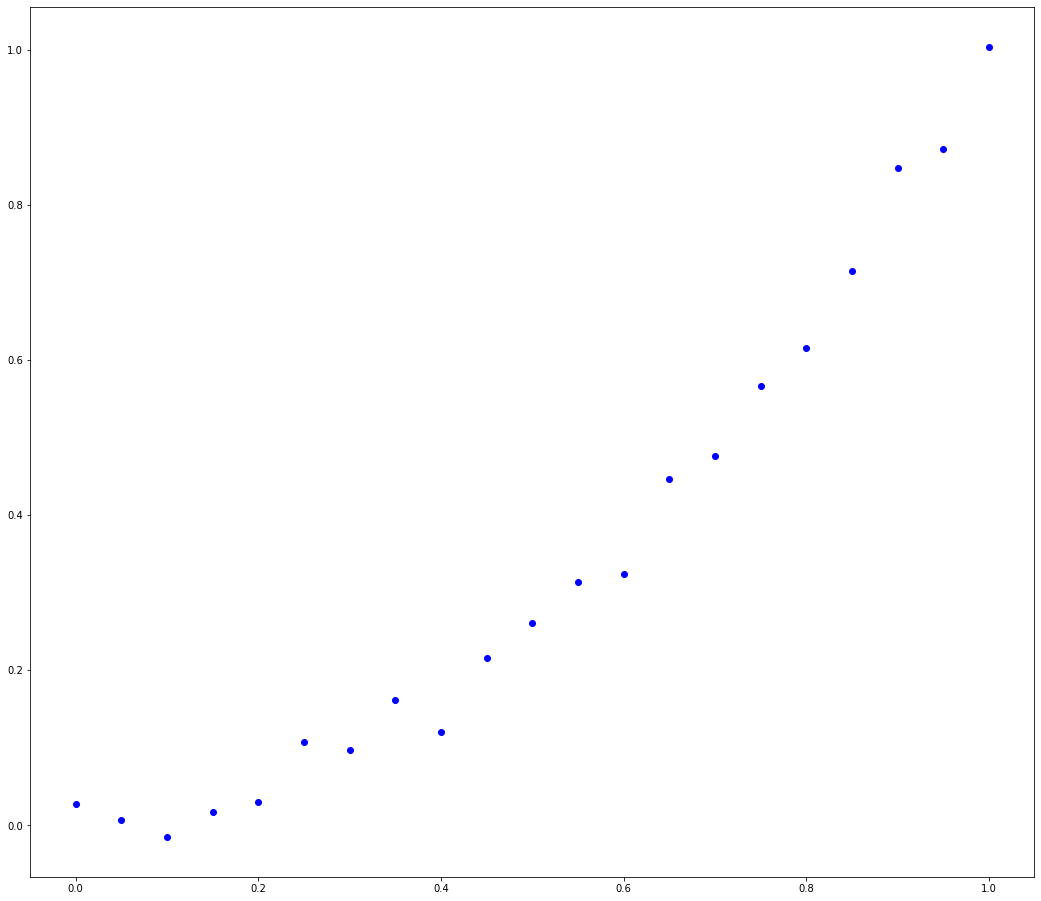

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18,16))

ax.plot(train_x.numpy(), train_y.numpy(), "bo")

___

In [10]:
class PVGPRegressionModel(gpytorch.models.PyroGP):
    def __init__(self, train_x, train_y, likelihood):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points = train_y.numel(),
        )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )

        super(PVGPRegressionModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix="simple regressional model"
        )

        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar =  self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [11]:
model = PVGPRegressionModel(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())

___

In [12]:
import os
smoke_test = ('CI' in os.environ)

In [14]:
num_iter = 2 if smoke_test else 200
num_particles = 1 if smoke_test else 256

In [15]:
def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr":0.1})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    iterator = tqdm.notebook.tqdm(range(num_iter))

    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss)

In [16]:
%time train()

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html